In [21]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), os.pardir))

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import norm
from io_utils import load_models, load_matrices_from_dir

In [23]:
matrix = "bcsstk18"
df = pd.read_csv(f"data/{matrix}_1000_testing.csv")
errorfree_iterations = df["errorfree_iterations"][0]
df.head()

,mat_name,errorfree_iterations,tol,maxiter,error_pos,error_iter,solve_iterations,final_relres,did_converge,realtime_s,pos_2norm,n_rows,slowdown
0,cbuckle.mat,341,0.000001,34100,12766,133,798,9.993116e-07,True,0.553754,373.369101,13681,2.340176
1,cbuckle.mat,341,0.000001,34100,9685,293,358,9.810659e-07,True,0.253908,485.237722,13681,1.049853
2,cbuckle.mat,341,0.000001,34100,2906,80,355,9.727220e-07,True,0.277555,99.923192,13681,1.041056
3,cbuckle.mat,341,0.000001,34100,10030,45,384,9.812118e-07,True,0.272684,373.369101,13681,1.126100
4,cbuckle.mat,341,0.000001,34100,9582,310,7608,9.999793e-07,True,5.194308,38410.569328,13681,22.310850


In [24]:
chosen_model = "./models/bcsstk18/best_KNeighborsRegressor_2024_01_09-02_23_36_PM.pkl"
# chosen_model = "./models/cbuckle/best_KNeighborsRegressor_2024_01_09-02_10_49_PM.pkl"
model = load_models([chosen_model])[0]
model

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('kneighborsregressor',
                 KNeighborsRegressor(n_neighbors=10, p=1.8733986290581737))])

In [25]:
X = df[["error_iter", "pos_2norm"]].to_numpy()
df["prot_score"] = model.predict(X)
df.head()

,mat_name,errorfree_iterations,tol,maxiter,error_pos,error_iter,solve_iterations,final_relres,did_converge,realtime_s,pos_2norm,n_rows,slowdown,prot_score
0,cbuckle.mat,341,0.000001,34100,12766,133,798,9.993116e-07,True,0.553754,373.369101,13681,2.340176,2.194135
1,cbuckle.mat,341,0.000001,34100,9685,293,358,9.810659e-07,True,0.253908,485.237722,13681,1.049853,1.187390
2,cbuckle.mat,341,0.000001,34100,2906,80,355,9.727220e-07,True,0.277555,99.923192,13681,1.041056,1.040762
3,cbuckle.mat,341,0.000001,34100,10030,45,384,9.812118e-07,True,0.272684,373.369101,13681,1.126100,1.138416
4,cbuckle.mat,341,0.000001,34100,9582,310,7608,9.999793e-07,True,5.194308,38410.569328,13681,22.310850,28.476540


In [26]:
ps = list(np.arange(1 / 98, 1.01, 0.01))
mean_prot_slowdowns = []
median_prot_slowdowns = []
mean_nonprot_slowdown = df["slowdown"].mean()
median_nonprot_slowdown = df["slowdown"].median()

for p in ps:
    df["should_protect"] = df["slowdown"] > (1 + (1 / p))
    df["did_protect"] = df["prot_score"] > (1 + (1 / p))
    df["prot_iterations"] = df.apply(lambda row: row["solve_iterations"] if not row["did_protect"]
                                     else row["errorfree_iterations"], axis=1)
    df["prot_slowdown"] = df["prot_iterations"] / df["errorfree_iterations"]
    mean_prot_slowdowns.append(df["prot_slowdown"].mean())
    median_prot_slowdowns.append(df["prot_slowdown"].median())

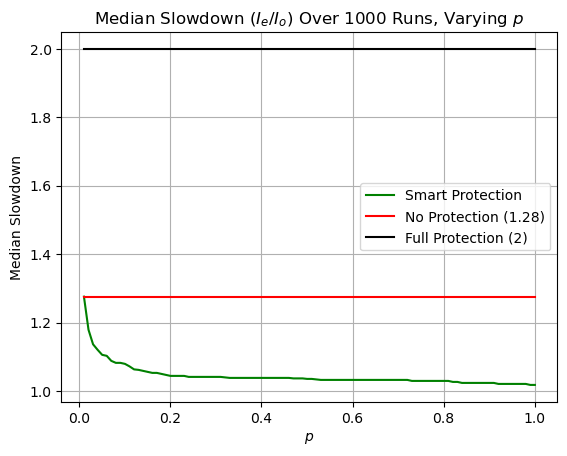

In [27]:
plt.plot(ps, median_prot_slowdowns,
         label=f"Smart Protection", c="green")
plt.plot(ps, [median_nonprot_slowdown] * len(ps),
         label=f"No Protection ({round(median_nonprot_slowdown, 2)})", c="red")
plt.plot(ps, [2] * len(ps), label="Full Protection (2)", c="black")
plt.xlabel("$p$")
plt.ylabel("Median Slowdown")
plt.title("Median Slowdown ($I_e / I_o$) Over 1000 Runs, Varying $p$ ")
plt.legend(loc="center right")
plt.grid()
plt.savefig(f"./figures/{matrix}/median_slowdowns.png")
plt.show()

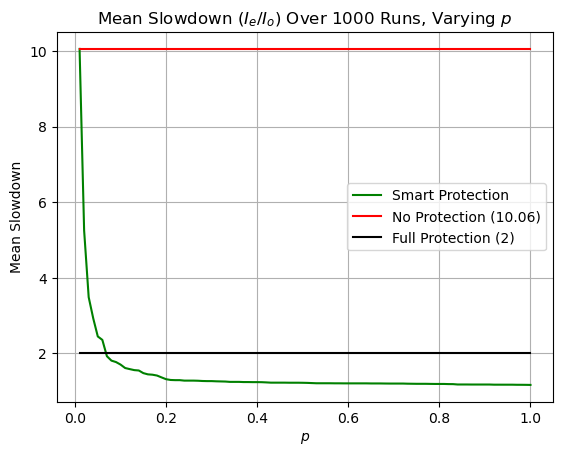

In [28]:
plt.plot(ps, mean_prot_slowdowns, label=f"Smart Protection", c="green")
plt.plot(ps, [mean_nonprot_slowdown] * len(ps),
         label=f"No Protection ({round(mean_nonprot_slowdown, 2)})", c="red")
plt.plot(ps, [2] * len(ps), label="Full Protection (2)", c="black")
plt.xlabel("$p$")
plt.ylabel("Mean Slowdown")
plt.title("Mean Slowdown ($I_e / I_o$) Over 1000 Runs, Varying $p$ ")
plt.legend()
plt.grid()
plt.savefig(f"./figures/{matrix}/mean_slowdowns.png")
plt.show()

In [29]:
mats = load_matrices_from_dir("../matrices/raw", subset=[matrix])
mat = list(mats.values())[0]
mat

<13681x13681 sparse matrix of type '<class 'numpy.float64'>'
	with 676515 stored elements in Compressed Sparse Column format>

In [30]:
pos_2norms = {pos: norm(mat.getrow(pos)) for pos in range(mat.shape[0])}
iter_norm_pairs = np.array([[i, pos_2norms[pos], pos] for pos in range(mat.shape[0])
                            for i in range(errorfree_iterations)])
df_preds = pd.DataFrame(iter_norm_pairs, columns=["i", "2norm", "rowid"])
df_preds["output"] = model.predict(df_preds[["i", "2norm"]].to_numpy())
df_preds_piv = df_preds.pivot(index=["2norm", "rowid"], columns="i", values="output")
df_preds_piv.head()

i                    0.0       1.0       2.0       3.0      4.0       5.0    \
2norm    rowid                                                                
3.566815 6841.0   1.174487  1.174487  1.174487  1.214663  1.17478  1.207918   
         1.0      1.174487  1.174487  1.174487  1.214663  1.17478  1.207918   
         10262.0  1.174487  1.174487  1.174487  1.214663  1.17478  1.207918   
         3422.0   1.174487  1.174487  1.174487  1.214663  1.17478  1.207918   
3.571172 6949.0   1.174487  1.174487  1.174487  1.214663  1.17478  1.207918   

i                    6.0       7.0      8.0       9.0    ...     331.0  \
2norm    rowid                                           ...             
3.566815 6841.0   1.203226  1.212903  1.24956  1.250147  ...  0.984164   
         1.0      1.203226  1.212903  1.24956  1.250147  ...  0.984164   
         10262.0  1.203226  1.212903  1.24956  1.250147  ...  0.984164   
         3422.0   1.203226  1.212903  1.24956  1.250147  ...  0.984164   
3.571172 6949.0   1.203226  1.212903  1.24956  1.250147  ...  0.984164   

i                    332.0     333.0     334.0     335.0     336.0     337.0  \
2norm    rowid                                                                 
3.566815 6841.0   0.991789  0.989736  0.989736  0.989736  0.992082  0.995308   
         1.0      0.991789  0.989736  0.989736  0.989736  0.992082  0.995308   
         10262.0  0.991789  0.989736  0.989736  0.989736  0.992082  0.995308   
         3422.0   0.991789  0.989736  0.989736  0.989736  0.992082  0.995308   
3.571172 6949.0   0.991789  0.989736  0.989736  0.989736  0.992082  0.995308   

i                    338.0     339.0     340.0  
2norm    rowid                                  
3.566815 6841.0   0.995308  0.995308  0.995308  
         1.0      0.995308  0.995308  0.995308  
         10262.0  0.995308  0.995308  0.995308  
         3422.0   0.995308  0.995308  0.995308  
3.571172 6949.0   0.995308  0.995308  0.995308  

[5 rows x 341 columns]

In [31]:
errorfree_op_count = df["errorfree_iterations"] * df["n_rows"]
nonprot_op_count = df["solve_iterations"] * df["n_rows"]
nonprot_overheads = (nonprot_op_count - errorfree_op_count) / errorfree_op_count
mean_prot_overheads = []
median_prot_overheads = []

prot_scores = df_preds_piv.to_numpy().T
n_prots_per_p = []

for p in ps:
    df["should_protect"] = df["slowdown"] > (1 + (1 / p))
    df["did_protect"] = df["prot_score"] > (1 + (1 / p))
    df["prot_iterations"] = df.apply(lambda row: row["solve_iterations"] if not row["did_protect"]
                                     else row["errorfree_iterations"], axis=1)
    protections = prot_scores > (1 + (1 / p))
    n_protections = protections.sum()
    n_prots_per_p.append(n_protections)
    prot_overheads = ((df["prot_iterations"] * df["n_rows"] + n_protections) - 
                      errorfree_op_count) / errorfree_op_count
    mean_prot_overheads.append(prot_overheads.mean())
    median_prot_overheads.append(prot_overheads.median())

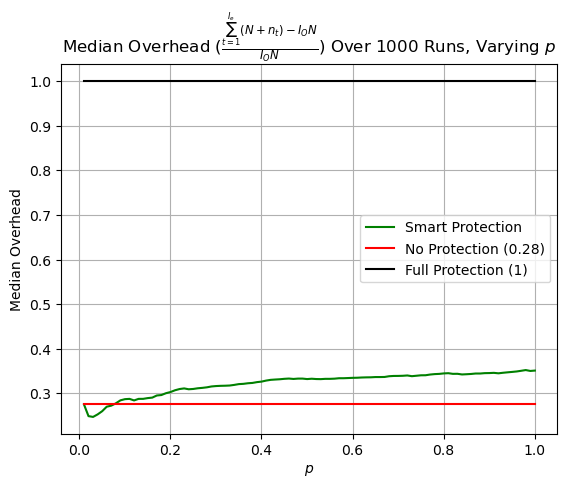

In [32]:
plt.plot(ps, median_prot_overheads,
         label=f"Smart Protection", c="green")
plt.plot(ps, [nonprot_overheads.median()] * len(ps),
         label=f"No Protection ({round(nonprot_overheads.median(), 2)})", c="red")
plt.plot(ps, [1] * len(ps), label="Full Protection (1)", c="black")
plt.xlabel("$p$")
plt.ylabel("Median Overhead")
overhead_formula = r"$ \frac{\sum_{t=1}^{I_e}(N + n_t) - I_ON}{I_ON} $"
plt.title(f"Median Overhead ({overhead_formula}) Over 1000 Runs, Varying $p$ ")
plt.legend()
plt.grid()
plt.savefig(f"./figures/{matrix}/median_overheads.png")
plt.show()

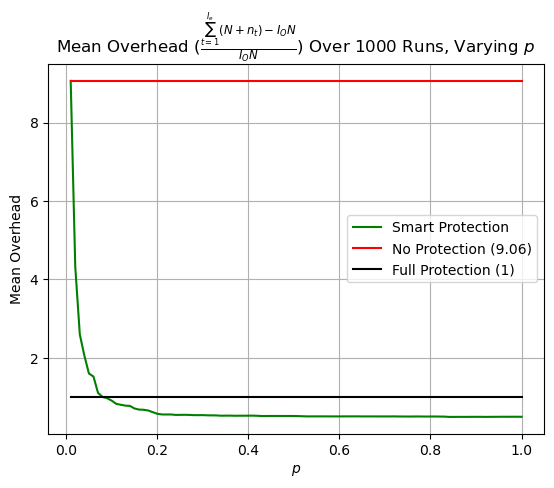

In [33]:
plt.plot(ps, mean_prot_overheads,
         label=f"Smart Protection", c="green")
plt.plot(ps, [nonprot_overheads.mean()] * len(ps),
         label=f"No Protection ({round(nonprot_overheads.mean(), 2)})", c="red")
plt.plot(ps, [1] * len(ps), label="Full Protection (1)", c="black")
plt.xlabel("$p$")
plt.ylabel("Mean Overhead")
overhead_formula = r"$ \frac{\sum_{t=1}^{I_e}(N + n_t) - I_ON}{I_ON} $"
plt.title(f"Mean Overhead ({overhead_formula}) Over 1000 Runs, Varying $p$ ")
plt.legend()
plt.grid()
plt.savefig(f"./figures/{matrix}/mean_overheads.png")
plt.show()

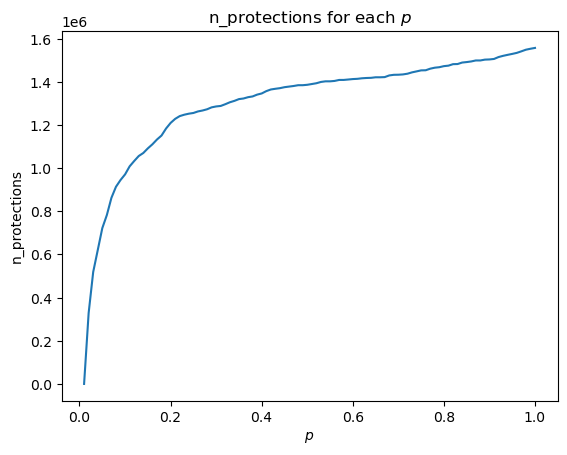

In [34]:
s = pd.Series(n_prots_per_p)
plt.plot(ps, s)
plt.title("n_protections for each $p$")
plt.xlabel("$p$")
plt.ylabel("n_protections")
plt.show()

count    1000.000000
mean       10.059938
std        21.553569
min         0.912023
25%         1.043988
50%         1.275660
75%         4.217742
max        99.997067
Name: slowdown, dtype: float64

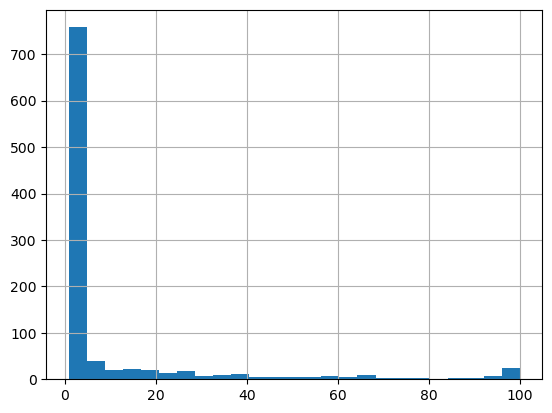

In [35]:
df["slowdown"].hist(bins=25);
df["slowdown"].describe()

count    1000.000000
mean        9.059938
std        21.553569
min        -0.087977
25%         0.043988
50%         0.275660
75%         3.217742
max        98.997067
dtype: float64

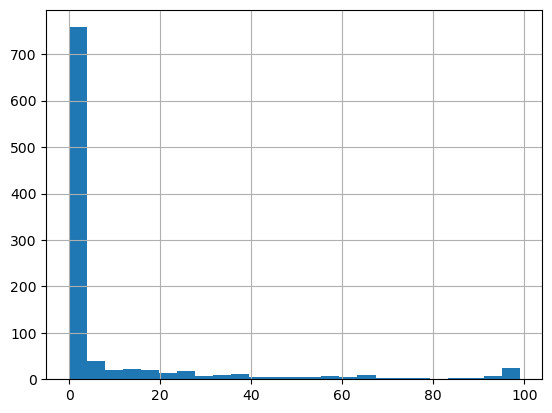

In [36]:
nonprot_overheads.hist(bins=25);
nonprot_overheads.describe()